In [1]:
import os
import ml_collections

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt


os.environ["CUDA_VISIBLE_DEVICES"] = '5'

In [ ]:
config_dict = {
    "alpha": 0,
    "x_start": -5,
    "x_end": 5,
    "train_size": 101,
    "test_size": 51,
    "layer_list": [200, 200, 200, 100],
    "seed": 0,
    "ActFun": "tanh",
    "dims_input": 1,
    "dims_output": 1,
    "lossfunc": "MSE",
    "optimizer": "Adam",
    "epochs": 300,
    "batch_size": 50,
    "lr": 2e-4,
    "lr_decayrate": 0,
    "lr_decaystep": 2000,
    "isFFT": True,
    "result_dir": 'results'
}
config = ml_collections.ConfigDict(config_dict)

# Basic Function
Design a target function by discretizing a smooth function $f_{0}(x)$ by
$$f(x) = \alpha * Round(f_{0}(x)/\alpha)$$
In the case, we use $f_{0}(x) = \sin(x) + 2\sin(x) + 3\sin(5x)$

In [3]:
def func0(xx):
    y_sin = np.sin(xx)+2*np.sin(3*xx)+3*np.sin(5*xx)
    return y_sin


def func_to_approx(xx, alpha):
    y_sin = func0(xx)
    if alpha == 0:
        return y_sin
    out_y = np.round(y_sin/alpha)
    out_y2 = out_y * alpha
    return out_y2


def get_data(config):
    train_input = np.reshape(np.linspace(config.x_start, config.x_end,
                             num=config.train_size, endpoint=True), [config.train_size, 1]).astype(np.float32)

    y_train = func_to_approx(train_input, config.alpha)

    return (train_input, y_train)

Text(0, 0.5, 'y')

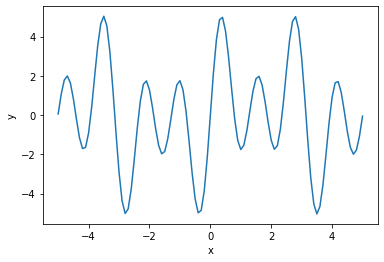

In [5]:
config.alpha = 0
train_data, test_data = get_data(config)
x, y = train_data
plt.plot(x, y)
plt.xlabel('x')
plt.ylabel('y')


In [4]:
def my_fft(data, freq_len=40, x_input=np.zeros(10), kk=0, min_f=0, max_f=np.pi/3, isnorm=1):
    second_diff_input = np.mean(np.diff(np.diff(np.squeeze(x_input))))
    if abs(second_diff_input) < 1e-10:
        datat = np.squeeze(data)
        datat_fft = np.fft.fft(datat)
        ind2 = range(freq_len)
        fft_coe = datat_fft[ind2]
        if isnorm == 1:
            return_fft = np.absolute(fft_coe)
        else:
            return_fft = fft_coe
    else:
        return_fft = get_ft_multi(
            x_input, data, kk=kk, freq_len=freq_len, min_f=min_f, max_f=max_f, isnorm=isnorm)
    return return_fft


def get_ft_multi(x_input, data, kk=0, freq_len=100, min_f=0, max_f=np.pi/3, isnorm=1):
    n = x_input.shape[1]
    if np.max(abs(kk)) == 0:
        k = np.linspace(min_f, max_f, num=freq_len, endpoint=True)
        kk = np.matmul(np.ones([n, 1]), np.reshape(k, [1, -1]))
    tmp = np.matmul(np.transpose(data), np.exp(-1J * (np.matmul(x_input, kk))))
    if isnorm == 1:
        return_fft = np.absolute(tmp)
    else:
        return_fft = tmp
    return np.squeeze(return_fft)


def SelectPeakIndex(FFT_Data, endpoint=True):
    D1 = FFT_Data[1:-1]-FFT_Data[0:-2]
    D2 = FFT_Data[1:-1]-FFT_Data[2:]
    D3 = np.logical_and(D1 > 0, D2 > 0)
    tmp = np.where(D3 == True)
    sel_ind = tmp[0]+1
    if endpoint:
        if FFT_Data[0]-FFT_Data[1] > 0:
            sel_ind = np.concatenate([[0], sel_ind])
        if FFT_Data[-1]-FFT_Data[-2] > 0:
            Last_ind = len(FFT_Data)-1
            sel_ind = np.concatenate([sel_ind, [Last_ind]])
    return sel_ind

In [5]:
class CustomModel(tf.keras.Model):
    def test_step(self, data):
        x, y = data
        y_pred = self(x, training=False)
        # self.compiled_loss(y, y_pred)
        # self.compiled_metrics.update_state(y, y_pred)

        return_metrics = {}
        # for metric in self.metrics:
        #     return_metrics[metric.name] = metric.result()
        return_metrics['y_pred'] = y_pred

        return return_metrics

In [6]:
input = tf.keras.Input(shape=(config.dims_input, ))
x = input
for layer in config.layer_list:
    x = tf.keras.layers.Dense(layer, activation=config.ActFun)(x)
output = tf.keras.layers.Dense(config.dims_output)(x)

model = CustomModel(input, output)

In [24]:
train_data, test_data = get_data(config)
x, y = train_data
opt = tf.keras.optimizers.__dict__[config.optimizer](lr=config.lr)
model.compile(optimizer=opt, loss='mse')
history = model.fit(x, y, batch_size=101,epochs=config.epochs, validation_data=test_data)

Epoch 1/300
1/1 [==============================] - 1s 524ms/step - loss: 3.0087 - val_loss: 2.8662 - val_y_pred: -0.0058
Epoch 2/300
1/1 [==============================] - 0s 39ms/step - loss: 2.8755 - val_loss: 2.9393 - val_y_pred: -0.0060
Epoch 3/300
1/1 [==============================] - 0s 35ms/step - loss: 2.9505 - val_loss: 2.8943 - val_y_pred: -0.0061
Epoch 4/300
1/1 [==============================] - 0s 40ms/step - loss: 2.9045 - val_loss: 2.8373 - val_y_pred: -0.0059
Epoch 5/300
1/1 [==============================] - 0s 39ms/step - loss: 2.8462 - val_loss: 2.8426 - val_y_pred: -0.0054
Epoch 6/300
1/1 [==============================] - 0s 39ms/step - loss: 2.8510 - val_loss: 2.8723 - val_y_pred: -0.0044
Epoch 7/300
1/1 [==============================] - 0s 39ms/step - loss: 2.8804 - val_loss: 2.8633 - val_y_pred: -0.0029
Epoch 8/300
1/1 [==============================] - 0s 39ms/step - loss: 2.8716 - val_loss: 2.8311 - val_y_pred: -0.0012
Epoch 9/300
1/1 [======================

In [25]:
train_loss = history.history['loss']

(51, 1)